# A completely randomized design in R 

In [1]:
# Load needed packages
library(tidyverse)
library(ggplot2)
library(ggplot2)
library(acepack)
library(emmeans)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.4
✔ tibble  3.0.1     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In this lesson, we will carefully analyze a completely randomized design using data relevant to a data science application.

Let's consider the study introduced in the previous lesson, of pre-treated ‘patches of cloth’ or ‘bands’ on the rate of mosquito bites in male military personnel in India. The authors of the study write that "the difficulty with insecticide treated mosquito nets is that in military operation, it may not be practical for the personnel to carry mosquito nets with them. In mobile military operations, availability of pre-treated ‘patches of cloth’ or ‘bands’, which can be applied over the uniform at strategic sites, could be a feasible alternative."


The bands were treated with different mosquito repellants:

Variables:
1. bands/treatment:
    1. Odomos
    2. Deltamethrin
    3. Cyfluthrin
    4. D+O
    5. C+O

2. Per-man hour biting rate

This [experiment](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4925378/) was a "randomized controlled field trial, undertaken in a military garrison in the Northeastern part of the country, known to be endemic for MT malaria, over a period of six months from July to December 2003." The reference population was defined as “all serving male personnel of the Indian Army, deployed in the North-East“. This experiment can be thought of as a CRD. The treatments — i.e., bands treated with different repellants — were assigned randomly to experimental units—i.e., male personnel of the Indian Army, deployed in the North-East.

The controll, in this experiment, is the first level of the factor, that is, the Odomos repellant. 

First, we'll read in the data, and do some cleaning/manipulating:

In [2]:
# Load the data
mosq = read.csv("mosquito_patch.csv")

names(mosq) = c("treatment", "y") #rename the variables
mosq$treatment = as.factor(mosq$treatment) #store the treatment as a factor.
mosq$treatment = recode(mosq$treatment, "1" = "O", "2" = "D", 
                        "3" = "C", "4" = "D + O", "5" = "C + O") #rename the levels of the factor
summary(mosq) #show summary of the data

 treatment        y         
 O    :30   Min.   : 0.260  
 D    :30   1st Qu.: 5.160  
 C    :30   Median : 6.745  
 D + O:30   Mean   : 7.153  
 C + O:30   3rd Qu.: 9.098  
            Max.   :18.010  

Next, let's visually explore the data with a violin plot (a box plot would be acceptable too!). 

Saving 6.67 x 6.67 in image

`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 5 rows containing missing values (geom_segment).”
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 5 rows containing missing values (geom_segment).”


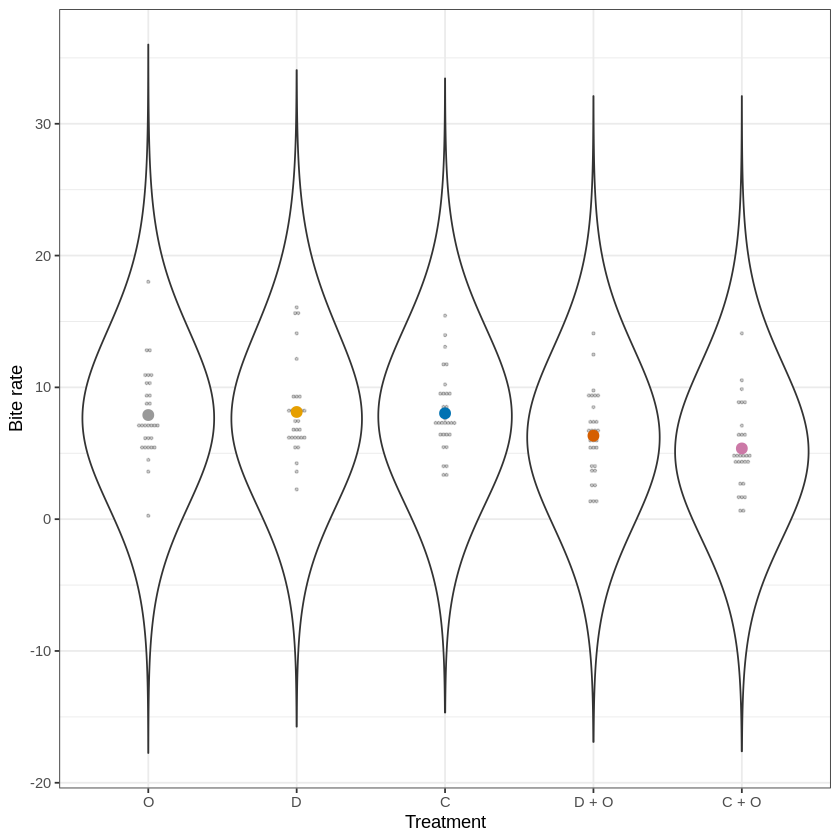

In [6]:
p = ggplot(mosq, aes(x = treatment, y = y)) 
p = p + geom_violin(trim=FALSE, bw = 6)
p = p + geom_dotplot(binaxis='y', stackdir='center', dotsize=0.4, alpha = 0.2)
p = p + stat_summary(fun = mean,  color=c("#999999", "#E69F00", "#0072B2", "#D55E00", "#CC79A7"), 
                     alpha = 1) 
p = p + xlab("Treatment") + ylab("Bite rate")
p = p + theme_bw() 
p = p + ggsave("~/mosq-violin.pdf")
p

Visually, we can see that there are differences across sample means. But given the distributions of the response within each treatment, it's not clear that those differences reflect actual differences in the population. We can analyze those differences further, and more formally using one-way ANOVA. Note that one-way ANOVA is the mathematical/statistical tool that is used on CRDs. If the CRD assumptions are met, then we can feel confidence in drawing causal conclusions. Let $\alpha = 0.05$.

In [11]:
a = lm(y ~ treatment, data = mosq)
summary(a)


Call:
lm(formula = y ~ treatment, data = mosq)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.6407 -2.0188 -0.5438  1.5272 10.1093 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)      7.9007     0.5861  13.481  < 2e-16 ***
treatmentD       0.2323     0.8288   0.280  0.77964    
treatmentC       0.1320     0.8288   0.159  0.87369    
treatmentD + O  -1.5673     0.8288  -1.891  0.06062 .  
treatmentC + O  -2.5337     0.8288  -3.057  0.00266 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.21 on 145 degrees of freedom
Multiple R-squared:   0.11,	Adjusted R-squared:  0.08544 
F-statistic:  4.48 on 4 and 145 DF,  p-value: 0.001924


Note that the F-test is significant ($p = 0.0019$), and thus we reject $$H_0: \text{The mean of the bite rate is the same across treatments}$$ and conclude that $$H_1: \text{There is some difference in the mean of the bite rate across treatments.}$$ 

Of course this does not tell us that much, but it allows us to perform post hoc tests. Here, we'll use the Tukey HSD method.

In [12]:
pairs(emmeans(a, "treatment"), adjust = "tukey")

 contrast          estimate    SE  df t.ratio p.value
 O - D               -0.232 0.829 145 -0.280  0.9986 
 O - C               -0.132 0.829 145 -0.159  0.9999 
 O - (D + O)          1.567 0.829 145  1.891  0.3268 
 O - (C + O)          2.534 0.829 145  3.057  0.0220 
 D - C                0.100 0.829 145  0.121  1.0000 
 D - (D + O)          1.800 0.829 145  2.171  0.1965 
 D - (C + O)          2.766 0.829 145  3.337  0.0094 
 C - (D + O)          1.699 0.829 145  2.050  0.2477 
 C - (C + O)          2.666 0.829 145  3.216  0.0137 
 (D + O) - (C + O)    0.966 0.829 145  1.166  0.7707 

P value adjustment: tukey method for comparing a family of 5 estimates 

We note that:

1. The difference between  O and C + O is statistically significant ($p = 0.0220$). That difference is estimated to be $2.534$. So, C + O reduces the bite rate by $2.534$, on average. 


2. The difference between D and C + O  is statistically significant ($p = 0.0094$). That difference is estimated to be $2.766$. So, C + O reduces the bite rate by $2.766$, on average. 


3. The difference between C - C + O  is statistically significant ($p = 0.0137$). That difference is estimated to be $2.666$. So, C + O reduces the bite rate by $2.666$, on average. 

If we are reasonbly sure that the CRD conditions are met, then it is plausible that the conclusions here can be interpreted causally for the relevant population (i.e., “all serving male personnel of the Indian Army, deployed in the North-East"). That is, if each experimental unit in the sample (male personnel of the Indian Army, deployed in the North-East) had the same chance of receiving any treatment, then we could say, for example, that on average,  C + O *caused* a $2.666$ drop in the bite rate, when compared to C.



Note that the conclusions below are the ones drawn in the research paper. They used Fisher's Least Significant Difference Method, which we did not study. This method is very liberal, and so we notice that the paper claims that there are more statistically significant differences than are claimed using the Tukey HSD Method.

a)
The difference in repellent action of odomos and deltamethrin patches was not significant (p > 0.1). Hence no significant benefit can be obtained by applying only deltamethrin patches in the absence of odomos.

b)
The difference between the repellent action of odomos and cyfluthrin was also not significant (p > 0.1), hence no significant benefit can be obtained by applying only cyfluthrin treated patches in the absence of odomos.

c)
Significant difference was found in the repellent action when odomos was used alone and when used along with deltamethrin treated patches, with the latter having significantly higher repellent action as compared to only odomos group(p < 0.05).

d)
Cyfluthrin patches when applied in presence of odomos were found to have much more repellent action as compared to only odomos. The difference in the repellent action was very highly significant (p < 0.001). Thus it can be inferred that significant benefit is achieved in reducing man-mosquito contact when cyfluthrin patches are applied over the uniform by the troops in addition to using odomos as compared to those using odomos only.

e)
No significant difference was found in the repellent action of deltamethrin and cyfluthrin patches in the absence of odomos. Thus, no significant benefit was found in using either deltamethrin or cyfluthrin patches in the absence of odomos (p > 0.1) or as compared to those using odomos only.

f)
Deltamethrin patches when used after applying odomos were found to be significantly better in reducing man-mosquito contact as compared to only deltamethrin patches (p < 0.01).

g)
Cyfluthrin patches after applying odomos were found to be more effective as repellent as compared to only deltamethrin patches applied without odomos (p < 0.001)

h)
Deltamethrin patches applied after applying odomos were significantly better repellent as compared to only cyfluthrin patches (p < 0.005).

j)
Cyfluthrin patches when used in presence of odomos were a much better repellent as compared to only cyfluthrin patches without odomos (p < 0.001).

k)
Deltamethrin patches and cyfluthrin patches in presence of odomos were not significantly different in their repellent action (p > 0.05). Hence no significant benefit can be offered by deltamethrin or cyfluthrin patches over one another when used in the presence of odomos.